# Breast Cancer Project
# Lymph Node Metastasis Prediction Using miRNA Expression Data
# Feature Selection 4th Step

## Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC

## Import Function

In [4]:
def read_object(obj_path):
    with open(obj_path, 'rb') as input:
        return pickle.load(input)

def save_object(obj, dir_path, file_name, file_extension='pkl', create_dir=True):
    if create_dir:
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
    name = os.path.normpath(os.path.join(dir_path, file_name+'.'+file_extension))
    with open(name, 'wb') as output:  # overwrites any existing file
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        return name

In [5]:
# Written by Greg Ver Steeg (http://www.isi.edu/~gregv/npeet.html)

import scipy.spatial as ss
from scipy.special import digamma
from math import log
import numpy.random as nr
import numpy as np
import random


# continuous estimators

def entropy(x, k=3, base=2):
    """
    The classic K-L k-nearest neighbor continuous entropy estimator x should be a list of vectors,
    e.g. x = [[1.3],[3.7],[5.1],[2.4]] if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x)-1, "Set k smaller than num. samples - 1"
    d = len(x[0])
    N = len(x)
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    tree = ss.cKDTree(x)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    const = digamma(N)-digamma(k) + d*log(2)
    return (const + d*np.mean(map(log, nn)))/log(base)


def mi(x, y, k=3, base=2):
    """
    Mutual information of x and y; x, y should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    points = zip2(x, y)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(x, dvec), avgdigamma(y, dvec), digamma(k), digamma(len(x))
    return (-a-b+c+d)/log(base)


def cmi(x, y, z, k=3, base=2):
    """
    Mutual information of x and y, conditioned on z; x, y, z should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    intens = 1e-10  # small noise to break degeneracy, see doc.
    x = [list(p + intens * nr.rand(len(x[0]))) for p in x]
    y = [list(p + intens * nr.rand(len(y[0]))) for p in y]
    z = [list(p + intens * nr.rand(len(z[0]))) for p in z]
    points = zip2(x, y, z)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = ss.cKDTree(points)
    dvec = [tree.query(point, k+1, p=float('inf'))[0][k] for point in points]
    a, b, c, d = avgdigamma(zip2(x, z), dvec), avgdigamma(zip2(y, z), dvec), avgdigamma(z, dvec), digamma(k)
    return (-a-b+c+d)/log(base)


def kldiv(x, xp, k=3, base=2):
    """
    KL Divergence between p and q for x~p(x), xp~q(x); x, xp should be a list of vectors, e.g. x = [[1.3],[3.7],[5.1],[2.4]]
    if x is a one-dimensional scalar and we have four samples
    """

    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    assert k <= len(xp) - 1, "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n-1)
    tree = ss.cKDTree(x)
    treep = ss.cKDTree(xp)
    nn = [tree.query(point, k+1, p=float('inf'))[0][k] for point in x]
    nnp = [treep.query(point, k, p=float('inf'))[0][k-1] for point in x]
    return (const + d*np.mean(map(log, nnp))-d*np.mean(map(log, nn)))/log(base)


# Discrete estimators
def entropyd(sx, base=2):
    """
    Discrete entropy estimator given a list of samples which can be any hashable object
    """

    return entropyfromprobs(hist(sx), base=base)


def midd(x, y):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return -entropyd(list(zip(x, y)))+entropyd(x)+entropyd(y)


def cmidd(x, y, z):
    """
    Discrete mutual information estimator given a list of samples which can be any hashable object
    """

    return entropyd(list(zip(y, z)))+entropyd(list(zip(x, z)))-entropyd(list(zip(x, y, z)))-entropyd(z)


def hist(sx):
    # Histogram from list of samples
    d = dict()
    for s in sx:
        d[s] = d.get(s, 0) + 1
    return map(lambda z: float(z)/len(sx), d.values())


def entropyfromprobs(probs, base=2):
    # Turn a normalized list of probabilities of discrete outcomes into entropy (base 2)
    return -sum(map(elog, probs))/log(base)


def elog(x):
    # for entropy, 0 log 0 = 0. but we get an error for putting log 0
    if x <= 0. or x >= 1.:
        return 0
    else:
        return x*log(x)


# Mixed estimators
def micd(x, y, k=3, base=2, warning=True):
    """ If x is continuous and y is discrete, compute mutual information
    """

    overallentropy = entropy(x, k, base)
    n = len(y)
    word_dict = dict()
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1./n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        if k <= len(xgiveny) - 1:
            mi -= word_dict[yval]*entropy(xgiveny, k, base)
        else:
            if warning:
                print("Warning, after conditioning, on y={0} insufficient data. Assuming maximal entropy in this case.".format(yval))
            mi -= word_dict[yval]*overallentropy
    return mi  # units already applied


# Utility functions
def vectorize(scalarlist):
    """
    Turn a list of scalars into a list of one-d vectors
    """

    return [(x,) for x in scalarlist]


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """
    Shuffle test
    Repeatedly shuffle the x-values and then estimate measure(x,y,[z]).
    Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs, 'measure' could me mi,cmi,
    e.g. Keyword arguments can be passed. Mutual information and CMI should have a mean near zero.
    """

    xp = x[:]   # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        random.shuffle(xp)
        if z:
            outputs.append(measure(xp, y, z, **kwargs))
        else:
            outputs.append(measure(xp, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (outputs[int((1.-ci)/2*ns)], outputs[int((1.+ci)/2*ns)])


# Internal functions
def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    for i in range(N):
        dist = dvec[i]
        # subtlety, we don't include the boundary point,
        # but we are implicitly adding 1 to kraskov def bc center point is included
        num_points = len(tree.query_ball_point(points[i], dist-1e-15, p=float('inf')))
        avg += digamma(num_points)/N
    return avg


def zip2(*args):
    # zip2(x,y) takes the lists of vectors and makes it a list of vectors in a joint space
    # E.g. zip2([[1],[2],[3]],[[4],[5],[6]]) = [[1,4],[2,5],[3,6]]
    return [sum(sublist, []) for sublist in zip(*args)]

In [6]:
def lcsi(X, y, **kwargs):
    """
    This function implements the basic scoring criteria for linear combination of shannon information term.
    The scoring criteria is calculated based on the formula j_cmi=I(f;y)-beta*sum_j(I(fj;f))+gamma*sum(I(fj;f|y))

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data, guaranteed to be a discrete data matrix
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        Parameters for different feature selection algorithms.
        beta: {float}
            beta is the parameter in j_cmi=I(f;y)-beta*sum(I(fj;f))+gamma*sum(I(fj;f|y))
        gamma: {float}
            gamma is the parameter in j_cmi=I(f;y)-beta*sum(I(fj;f))+gamma*sum(I(fj;f|y))
        function_name: {string}
            name of the feature selection function
        n_selected_features: {int}
            number of features to select

    Output
    ------
    F: {numpy array}, shape: (n_features,)
        index of selected features, F[0] is the most important feature
    J_CMI: {numpy array}, shape: (n_features,)
        corresponding objective function value of selected features
    MIfy: {numpy array}, shape: (n_features,)
        corresponding mutual information between selected features and response

    Reference
    ---------
    Brown, Gavin et al. "Conditional Likelihood Maximisation: A Unifying Framework for Information Theoretic Feature Selection." JMLR 2012.
    """

    n_samples, n_features = X.shape
    # index of selected features, initialized to be empty
    F = []
    # Objective function value for selected features
    J_CMI = []
    # Mutual information between feature and response
    MIfy = []
    # indicate whether the user specifies the number of features
    is_n_selected_features_specified = False
    # initialize the parameters
    if 'beta' in kwargs.keys():
        beta = kwargs['beta']
    if 'gamma' in kwargs.keys():
        gamma = kwargs['gamma']
    if 'n_selected_features' in kwargs.keys():
        n_selected_features = kwargs['n_selected_features']
        is_n_selected_features_specified = True

    # select the feature whose j_cmi is the largest
    # t1 stores I(f;y) for each feature f
    t1 = np.zeros(n_features)
    # t2 stores sum_j(I(fj;f)) for each feature f
    t2 = np.zeros(n_features)
    # t3 stores sum_j(I(fj;f|y)) for each feature f
    t3 = np.zeros(n_features)
    for i in range(n_features):
        f = X[:, i]
        t1[i] = midd(f, y)

    # make sure that j_cmi is positive at the very beginning
    j_cmi = 1

    while True:
        if len(F) == 0:
            # select the feature whose mutual information is the largest
            idx = np.argmax(t1)
            F.append(idx)
            J_CMI.append(t1[idx])
            MIfy.append(t1[idx])
            f_select = X[:, idx]

        if is_n_selected_features_specified:
            if len(F) == n_selected_features:
                break
        else:
            if j_cmi < 0:
                break

        # we assign an extreme small value to j_cmi to ensure it is smaller than all possible values of j_cmi
        j_cmi = -1E30
        if 'function_name' in kwargs.keys():
            if kwargs['function_name'] == 'MRMR':
                beta = 1.0 / len(F)
            elif kwargs['function_name'] == 'JMI':
                beta = 1.0 / len(F)
                gamma = 1.0 / len(F)
        for i in range(n_features):
            if i not in F:
                f = X[:, i]
                t2[i] += midd(f_select, f)
                t3[i] += cmidd(f_select, f, y)
                # calculate j_cmi for feature i (not in F)
                t = t1[i] - beta*t2[i] + gamma*t3[i]
                # record the largest j_cmi and the corresponding feature index
                if t > j_cmi:
                    j_cmi = t
                    idx = i
        F.append(idx)
        J_CMI.append(j_cmi)
        MIfy.append(t1[idx])
        f_select = X[:, idx]

    return np.array(F), np.array(J_CMI), np.array(MIfy)

In [7]:
def mrmr(X, y, **kwargs):
    """
    This function implements the MRMR feature selection

    Input
    -----
    X: {numpy array}, shape (n_samples, n_features)
        input data, guaranteed to be discrete
    y: {numpy array}, shape (n_samples,)
        input class labels
    kwargs: {dictionary}
        n_selected_features: {int}
            number of features to select

    Output
    ------
    F: {numpy array}, shape (n_features,)
        index of selected features, F[0] is the most important feature
    J_CMI: {numpy array}, shape: (n_features,)
        corresponding objective function value of selected features
    MIfy: {numpy array}, shape: (n_features,)
        corresponding mutual information between selected features and response

    Reference
    ---------
    Brown, Gavin et al. "Conditional Likelihood Maximisation: A Unifying Framework for Information Theoretic Feature Selection." JMLR 2012.
    """
    if 'n_selected_features' in kwargs.keys():
        n_selected_features = kwargs['n_selected_features']
        F, J_CMI, MIfy = lcsi(X, y, gamma=0, function_name='MRMR', n_selected_features=n_selected_features)
    else:
        F, J_CMI, MIfy = lcsi(X, y, gamma=0, function_name='MRMR')
    return F, J_CMI, MIfy

## Loading and Preparing Train and Test Data Matrix and Target Vector

In [8]:
dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/preprocessing/' 

file_name = 'Train Matrix.pkl'
train_matrix =read_object(dir_path+file_name)

file_name = 'Test Matrix.pkl'
test_matrix =read_object(dir_path+file_name)

file_name = 'Train Target.pkl'
train_target =read_object(dir_path+file_name)

file_name = 'Test Target.pkl'
test_target =read_object(dir_path+file_name)

dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/reading_breast_cancer/'

file_name = 'miRNA ID.pkl'
miRNA_id = read_object(dir_path + file_name)

dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/Feature_Selection (3rd step)/' 
file_name = 'Selected Features (3rd step).pkl'
miRNA_id_prime = read_object(dir_path + file_name)

In [9]:
train_samples_num = train_matrix.shape[0]
test_samples_num = test_matrix.shape[0]
features_num = len(miRNA_id_prime)
train_matrix_prime = np.zeros((train_samples_num, features_num))
test_matrix_prime = np.zeros((test_samples_num, features_num))
for i in range(features_num):
    index = np.argwhere(miRNA_id == miRNA_id_prime[i])
    train_matrix_prime[:,i] = train_matrix[:,index.item()]
    test_matrix_prime[:,i] = test_matrix[:,index.item()]

print(train_matrix_prime.shape)
print(test_matrix_prime.shape)


(492, 120)
(123, 120)


## Normalization 

In [10]:
scaler = MinMaxScaler()
scaler.fit(train_matrix_prime)
normal_train_matrix = scaler.transform(train_matrix_prime)
normal_test_matrix = scaler.transform(test_matrix_prime)

## Feature Selection

In [11]:
selected_num = 80
selected_index, j_cmi, mify = mrmr(normal_train_matrix, train_target, n_selected_features=selected_num)

In [12]:
print(selected_index.shape)
print(j_cmi.shape)
print(mify.shape)

(80,)
(80,)
(80,)


In [13]:
selected_index

array([ 10, 103,  67,  54,  86,   3,  40,  95, 107,  65,  63,  91,  30,
         4,  88,   6,  17,  50,  21,   5,   2,  48,  70,  38,  53,  68,
        56,  69, 105, 102,  34,  20,  14, 111,  46,  24,  84,  93,  28,
         0,   9,  11,   1,  59,  18,   8,  39,  37,  35,  15,  55,  51,
       113,  23,  16,  64, 117,  12, 106, 114,  57,  97,  66,  44,  79,
        76,  32, 101,  98,  19,  85,  77,  60,  62, 108,  29,  13,  27,
        22,  81])

In [14]:
selected_train_matrix = normal_train_matrix[:,selected_index]
selected_test_matrix = normal_test_matrix[:,selected_index]
selected_miRNA_id = miRNA_id_prime[selected_index]
print(selected_train_matrix.shape)
print(selected_test_matrix.shape)
print(selected_miRNA_id.shape)

(492, 80)
(123, 80)
(80,)


In [15]:
miRNA_id_prime

array(['hsa-mir-934', 'hsa-mir-202', 'hsa-mir-3654', 'hsa-mir-3181',
       'hsa-mir-3154', 'hsa-mir-559', 'hsa-mir-3679', 'hsa-mir-30e',
       'hsa-mir-7-2', 'hsa-mir-7-3', 'hsa-mir-10a', 'hsa-mir-320c-2',
       'hsa-mir-548b', 'hsa-mir-1247', 'hsa-mir-1538', 'hsa-mir-3136',
       'hsa-mir-3922', 'hsa-mir-668', 'hsa-mir-18b', 'hsa-mir-135b',
       'hsa-mir-3926-2', 'hsa-mir-506', 'hsa-mir-215', 'hsa-mir-577',
       'hsa-mir-658', 'hsa-mir-378c', 'hsa-mir-584', 'hsa-mir-3200',
       'hsa-mir-585', 'hsa-mir-616', 'hsa-mir-1243', 'hsa-mir-141',
       'hsa-mir-1248', 'hsa-mir-7-1', 'hsa-mir-3194', 'hsa-mir-579',
       'hsa-mir-378', 'hsa-mir-135a-1', 'hsa-mir-3178', 'hsa-mir-556',
       'hsa-mir-3128', 'hsa-mir-223', 'hsa-mir-196a-1', 'hsa-mir-146a',
       'hsa-mir-935', 'hsa-mir-219-1', 'hsa-mir-3680', 'hsa-mir-155',
       'hsa-mir-1914', 'hsa-mir-200a', 'hsa-mir-548f-1', 'hsa-mir-548o',
       'hsa-mir-576', 'hsa-mir-3622a', 'hsa-mir-3160-1', 'hsa-mir-1229',
       'hsa-mir-1

In [16]:
selected_miRNA_id

array(['hsa-mir-10a', 'hsa-mir-550b-1', 'hsa-mir-507', 'hsa-mir-3160-1',
       'hsa-mir-514b', 'hsa-mir-3181', 'hsa-mir-3128', 'hsa-mir-3116-2',
       'hsa-mir-3149', 'hsa-mir-520c', 'hsa-mir-2278', 'hsa-mir-572',
       'hsa-mir-1243', 'hsa-mir-3154', 'hsa-mir-1278', 'hsa-mir-3679',
       'hsa-mir-668', 'hsa-mir-548f-1', 'hsa-mir-506', 'hsa-mir-559',
       'hsa-mir-3654', 'hsa-mir-1914', 'hsa-mir-518e', 'hsa-mir-3178',
       'hsa-mir-3622a', 'hsa-mir-320e', 'hsa-mir-1251', 'hsa-mir-520b',
       'hsa-mir-519a-2', 'hsa-mir-516a-1', 'hsa-mir-3194',
       'hsa-mir-3926-2', 'hsa-mir-1538', 'hsa-mir-138-2', 'hsa-mir-3680',
       'hsa-mir-658', 'hsa-mir-138-1', 'hsa-mir-1255a', 'hsa-mir-585',
       'hsa-mir-934', 'hsa-mir-7-3', 'hsa-mir-320c-2', 'hsa-mir-202',
       'hsa-mir-3187', 'hsa-mir-18b', 'hsa-mir-7-2', 'hsa-mir-556',
       'hsa-mir-135a-1', 'hsa-mir-579', 'hsa-mir-3136', 'hsa-mir-1229',
       'hsa-mir-548o', 'hsa-mir-1292', 'hsa-mir-577', 'hsa-mir-3922',
       'hsa-mir-

## PCA and Visualization

In [17]:
pca = PCA(n_components=2)
pca.fit(selected_train_matrix)
train_pca_matrix = pca.transform(selected_train_matrix)
test_pca_matrix = pca.transform(selected_test_matrix)
print(train_pca_matrix.shape)
print(test_pca_matrix.shape)

(492, 2)
(123, 2)


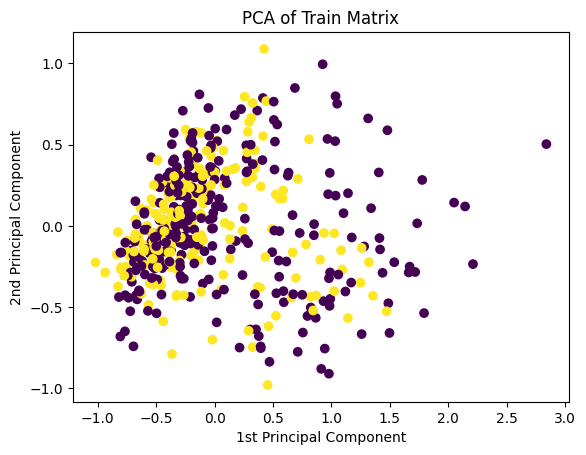

In [18]:
plt.Figure(figsize=(10,10))
fig = plt.scatter(train_pca_matrix[:,0], train_pca_matrix[:,1], c=train_target)
plt.title('PCA of Train Matrix')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

## Classifying based on the PCA Data Matrix

In [19]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(selected_train_matrix)
train_pca_matrix = pca.transform(selected_train_matrix)
test_pca_matrix = pca.transform(selected_test_matrix)
print(train_pca_matrix.shape)
print(test_pca_matrix.shape)

(492, 10)
(123, 10)


--------------------------------------------------
Training set based on PCA
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       286
           1       0.57      0.24      0.34       206

    accuracy                           0.61       492
   macro avg       0.59      0.56      0.53       492
weighted avg       0.60      0.61      0.56       492



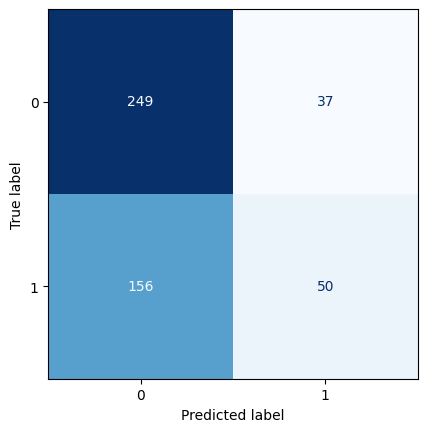

--------------------------------------------------
Test set based on PCA
              precision    recall  f1-score   support

           0       0.57      0.75      0.65        71
           1       0.40      0.23      0.29        52

    accuracy                           0.53       123
   macro avg       0.48      0.49      0.47       123
weighted avg       0.50      0.53      0.50       123



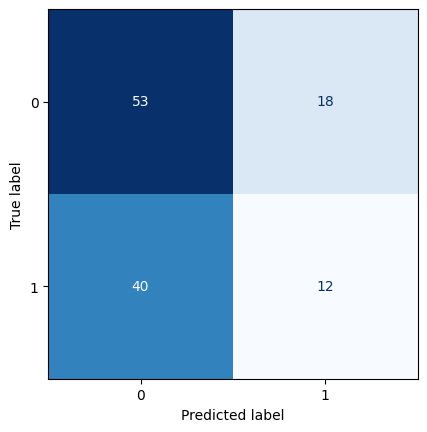

In [20]:
model = LinearDiscriminantAnalysis()
# model = QuadraticDiscriminantAnalysis()
# model = GaussianNB()
model.fit(train_pca_matrix, train_target)
train_pred = model.predict(train_pca_matrix)
test_pred = model.predict(test_pca_matrix)
print('-'*50)
print('Training set based on PCA')
print(classification_report(train_target, train_pred))

ConfusionMatrixDisplay.from_predictions(train_target, train_pred, cmap='Blues', colorbar=False)
plt.show()

print('-'*50)
print('Test set based on PCA')
print(classification_report(test_target, test_pred))
ConfusionMatrixDisplay.from_predictions(test_target, test_pred, cmap='Blues', colorbar=False)
plt.show()

--------------------------------------------------
Training set
              precision    recall  f1-score   support

           0       0.76      0.81      0.79       286
           1       0.72      0.65      0.68       206

    accuracy                           0.75       492
   macro avg       0.74      0.73      0.74       492
weighted avg       0.74      0.75      0.74       492



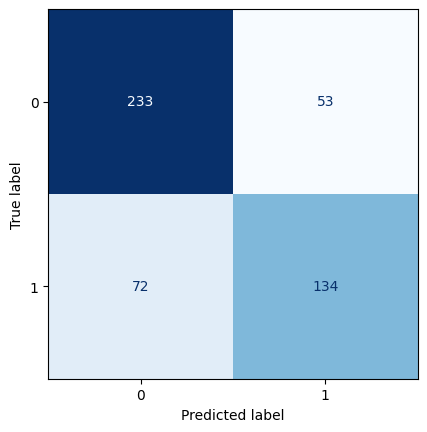

--------------------------------------------------
Test set
              precision    recall  f1-score   support

           0       0.60      0.54      0.57        71
           1       0.45      0.52      0.48        52

    accuracy                           0.53       123
   macro avg       0.53      0.53      0.52       123
weighted avg       0.54      0.53      0.53       123



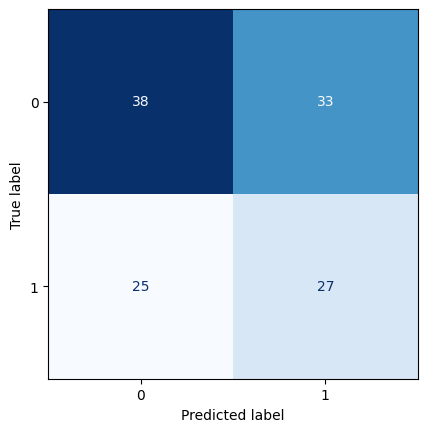

In [21]:
model = LinearDiscriminantAnalysis()
# model = QuadraticDiscriminantAnalysis()
# model = GaussianNB()
# model = SVC(kernel='linear')
model.fit(selected_train_matrix, train_target)
train_pred = model.predict(selected_train_matrix)
test_pred = model.predict(selected_test_matrix)
print('-'*50)
print('Training set')
print(classification_report(train_target, train_pred))

ConfusionMatrixDisplay.from_predictions(train_target, train_pred, cmap='Blues', colorbar=False)
plt.show()

print('-'*50)
print('Test set')
print(classification_report(test_target, test_pred))
ConfusionMatrixDisplay.from_predictions(test_target, test_pred, cmap='Blues', colorbar=False)
plt.show()

## Saving Result

In [22]:
dir_path = 'F:/internship/Breast Cancer Project (Lymph Node Metastasis)(miRNA)/Feature_Selection (4th step)/' 
file_name = 'Selected Features (4th step)'
save_object(selected_miRNA_id, dir_path, file_name)

'F:\\internship\\Breast Cancer Project (Lymph Node Metastasis)(miRNA)\\Feature_Selection (4th step)\\Selected Features (4th step).pkl'